In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import FunctionTransformer

In [2]:
#Data loading and Initial Exploration
df = pd.read_csv(r'D:\OneDrive - ECPI University\School\Combined Capstone\Ames Housing Dataset\AmesHousing.csv')
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset Info:")
df.info()

First 5 rows of the dataset:
   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Co

The features below have missing values. Categorical features will have 'None' entered 
while numerical features will be handled via some method of imputation.
Pool QC
Misc Feature
Alley
Fence
Mas Vnr Type
Fireplace Qu
Lot Frontage
Garage Yr Blt
Garage Finish
Garage Qual
Garage Cond
Garage Type
Bsmt Exposure
BsmtFin Type 2
Bsmt Qual
Bsmt Cond
BsmtFin Type 1
Mas Vnr Area
Bsmt Full Bath
Bsmt Half Bath
BsmtFin SF 1
BsmtFin SF 2
Bsmt Unf SF
Total Bsmt SF
Electrical
Garage Cars
Garage Area

Univariate Analysis

In [3]:
#define numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#define categorial features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

#show summary statistics for central tendancy
print(f"\nSummary Statistics for {len(numerical_features)} Identified Numerical Features:")
print(df[numerical_features].describe())


Summary Statistics for 39 Identified Numerical Features:
            Order           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2930.00000  2.930000e+03  2930.000000   2440.000000    2930.000000   
mean   1465.50000  7.144645e+08    57.387372     69.224590   10147.921843   
std     845.96247  1.887308e+08    42.638025     23.365335    7880.017759   
min       1.00000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     733.25000  5.284770e+08    20.000000     58.000000    7440.250000   
50%    1465.50000  5.354536e+08    50.000000     68.000000    9436.500000   
75%    2197.75000  9.071811e+08    70.000000     80.000000   11555.250000   
max    2930.00000  1.007100e+09   190.000000    313.000000  215245.000000   

       Overall Qual  Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  \
count   2930.000000   2930.000000  2930.000000     2930.000000   2907.000000   
mean       6.094881      5.563140  1971.356314     1984.266553    101.896801   
std     

Numerical features 'Lot Frontage' and Mas 'Vnr Area' have missing values.


Histograms:


<function matplotlib.pyplot.show(close=None, block=None)>

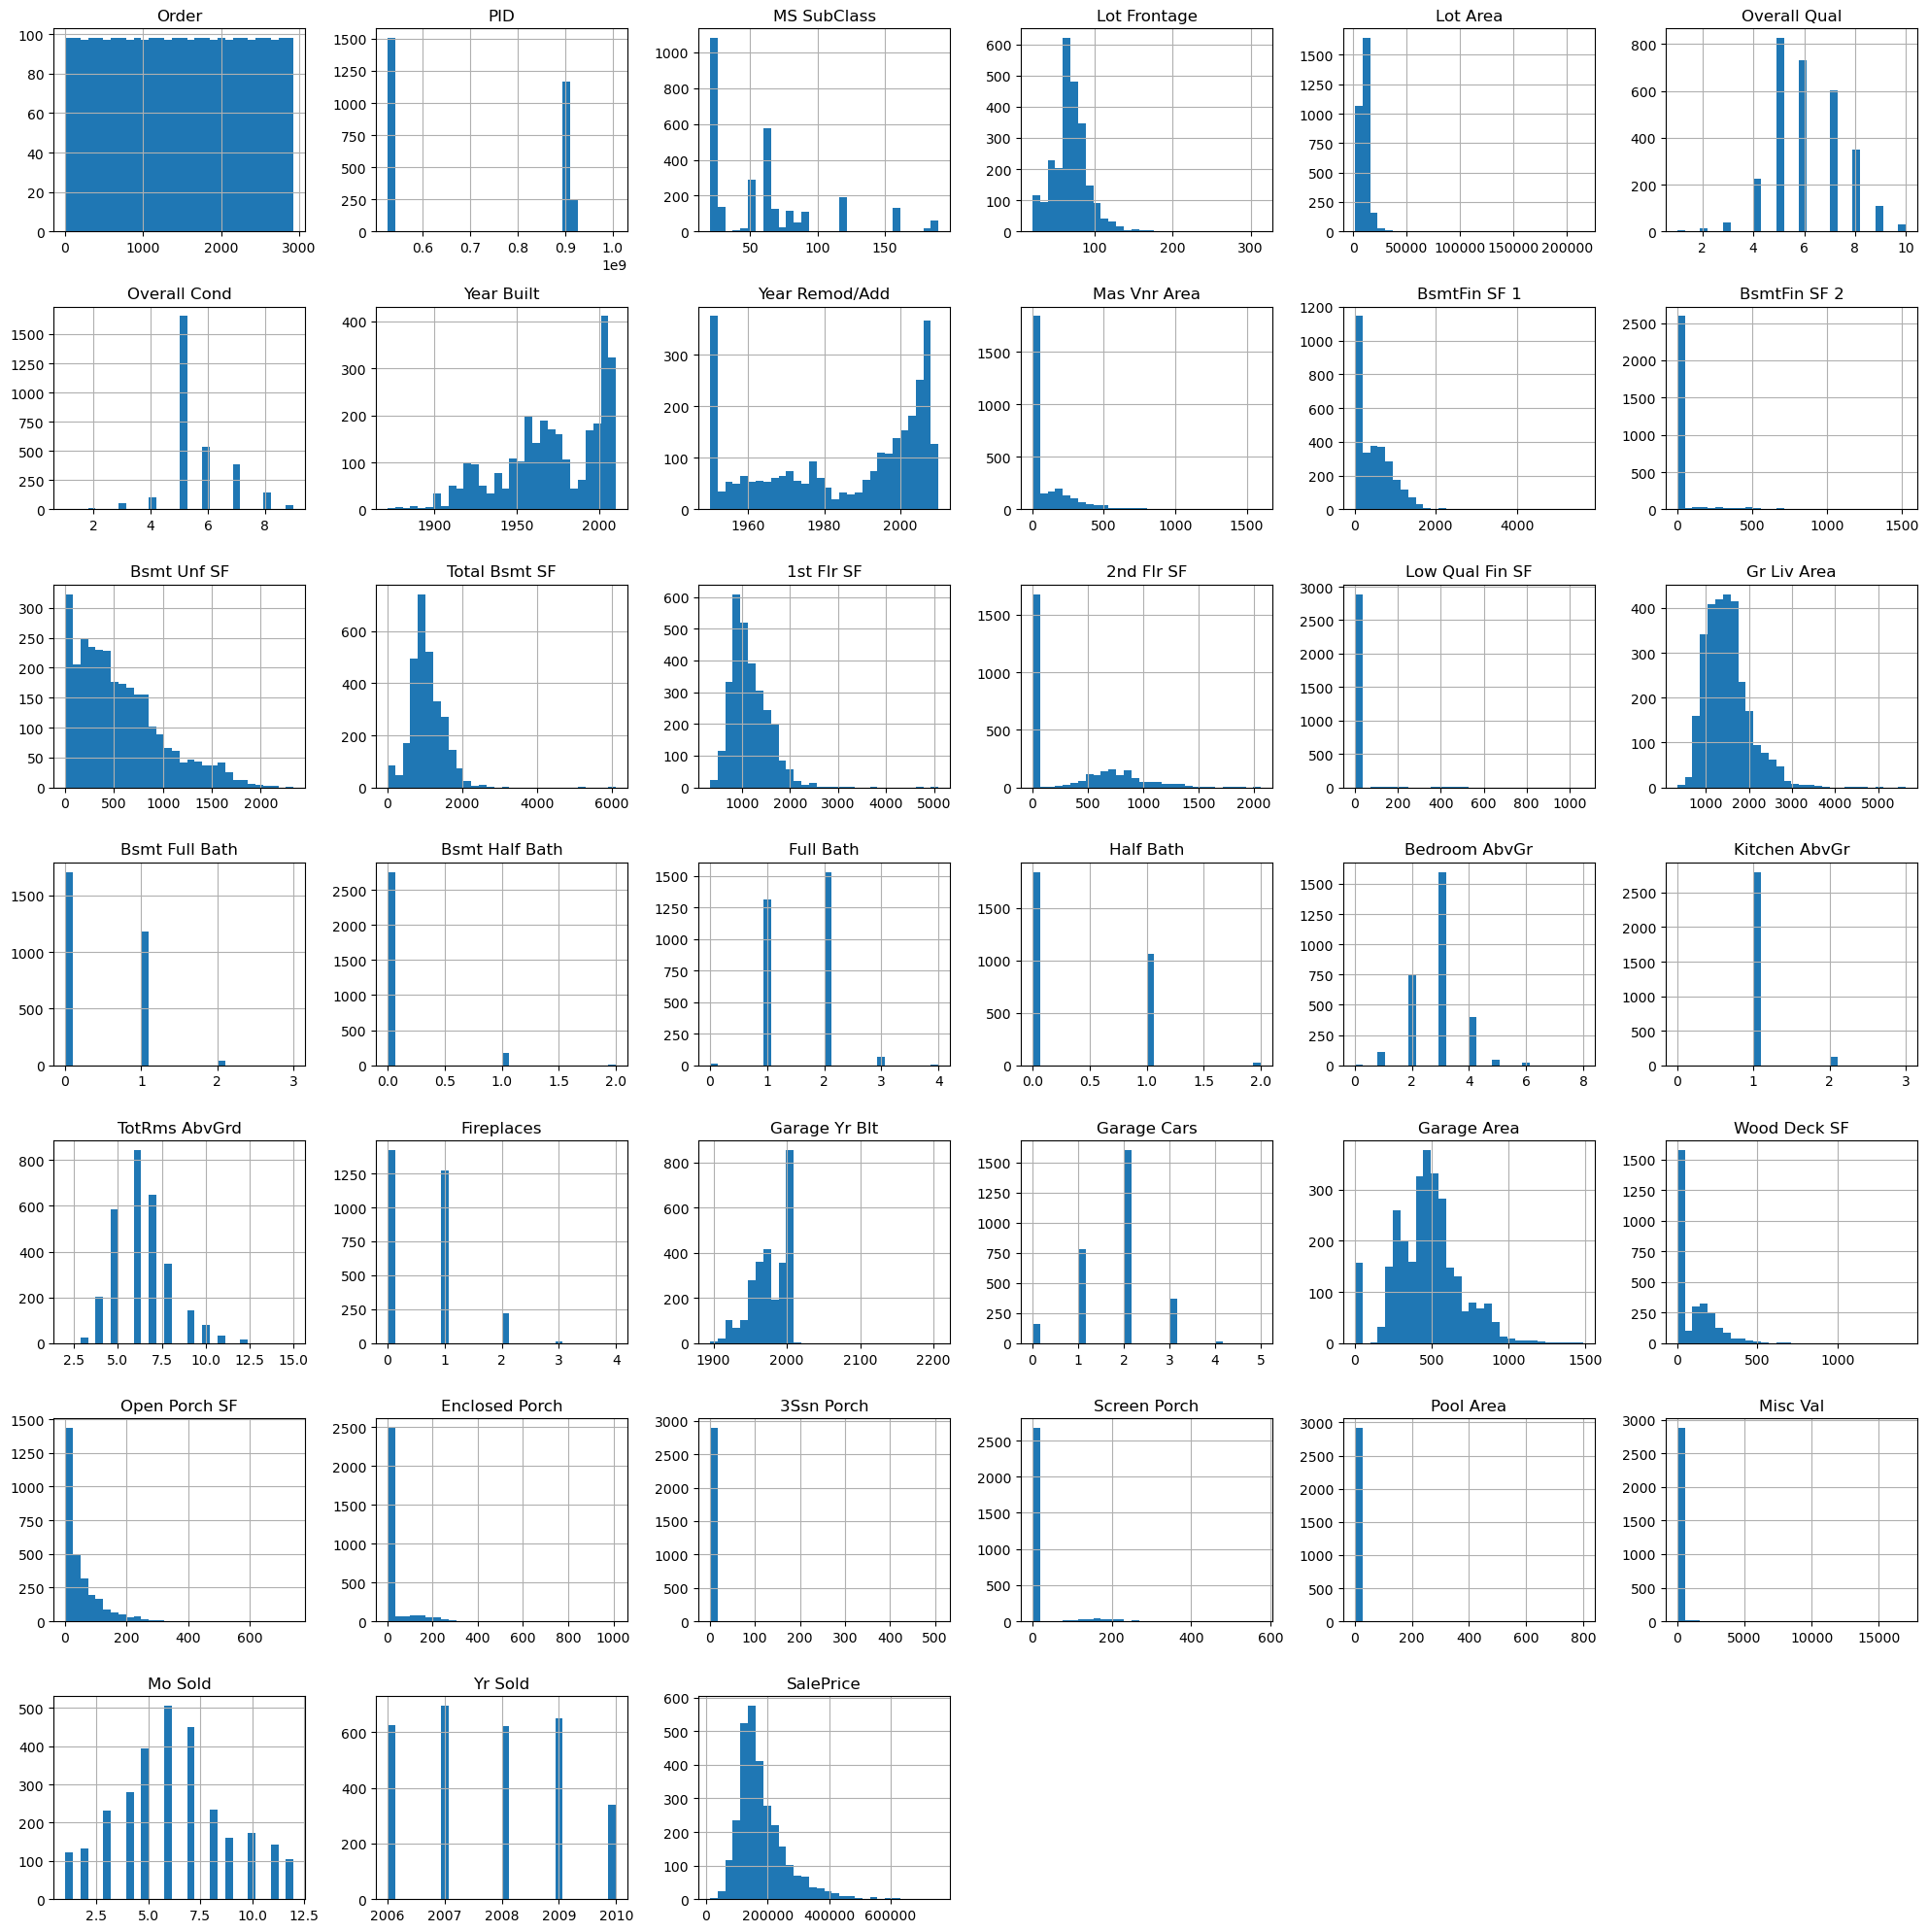

In [10]:
#Histograms to visualize distribution of numerical features
print("\nHistograms:")
df[numerical_features].hist(bins=30, figsize=(20,20))
plt.tight_layout()
plt.show

'Order' and 'PID' are identifiers and will be dropped
'MS SubClass' is categorical and will be one-hot encoded
Several plots are heavily skewed and may require log transformation
Numerical features have a very wide range of values which could negatively impact a neural network so numerical features will be standardized.


Box Plots:


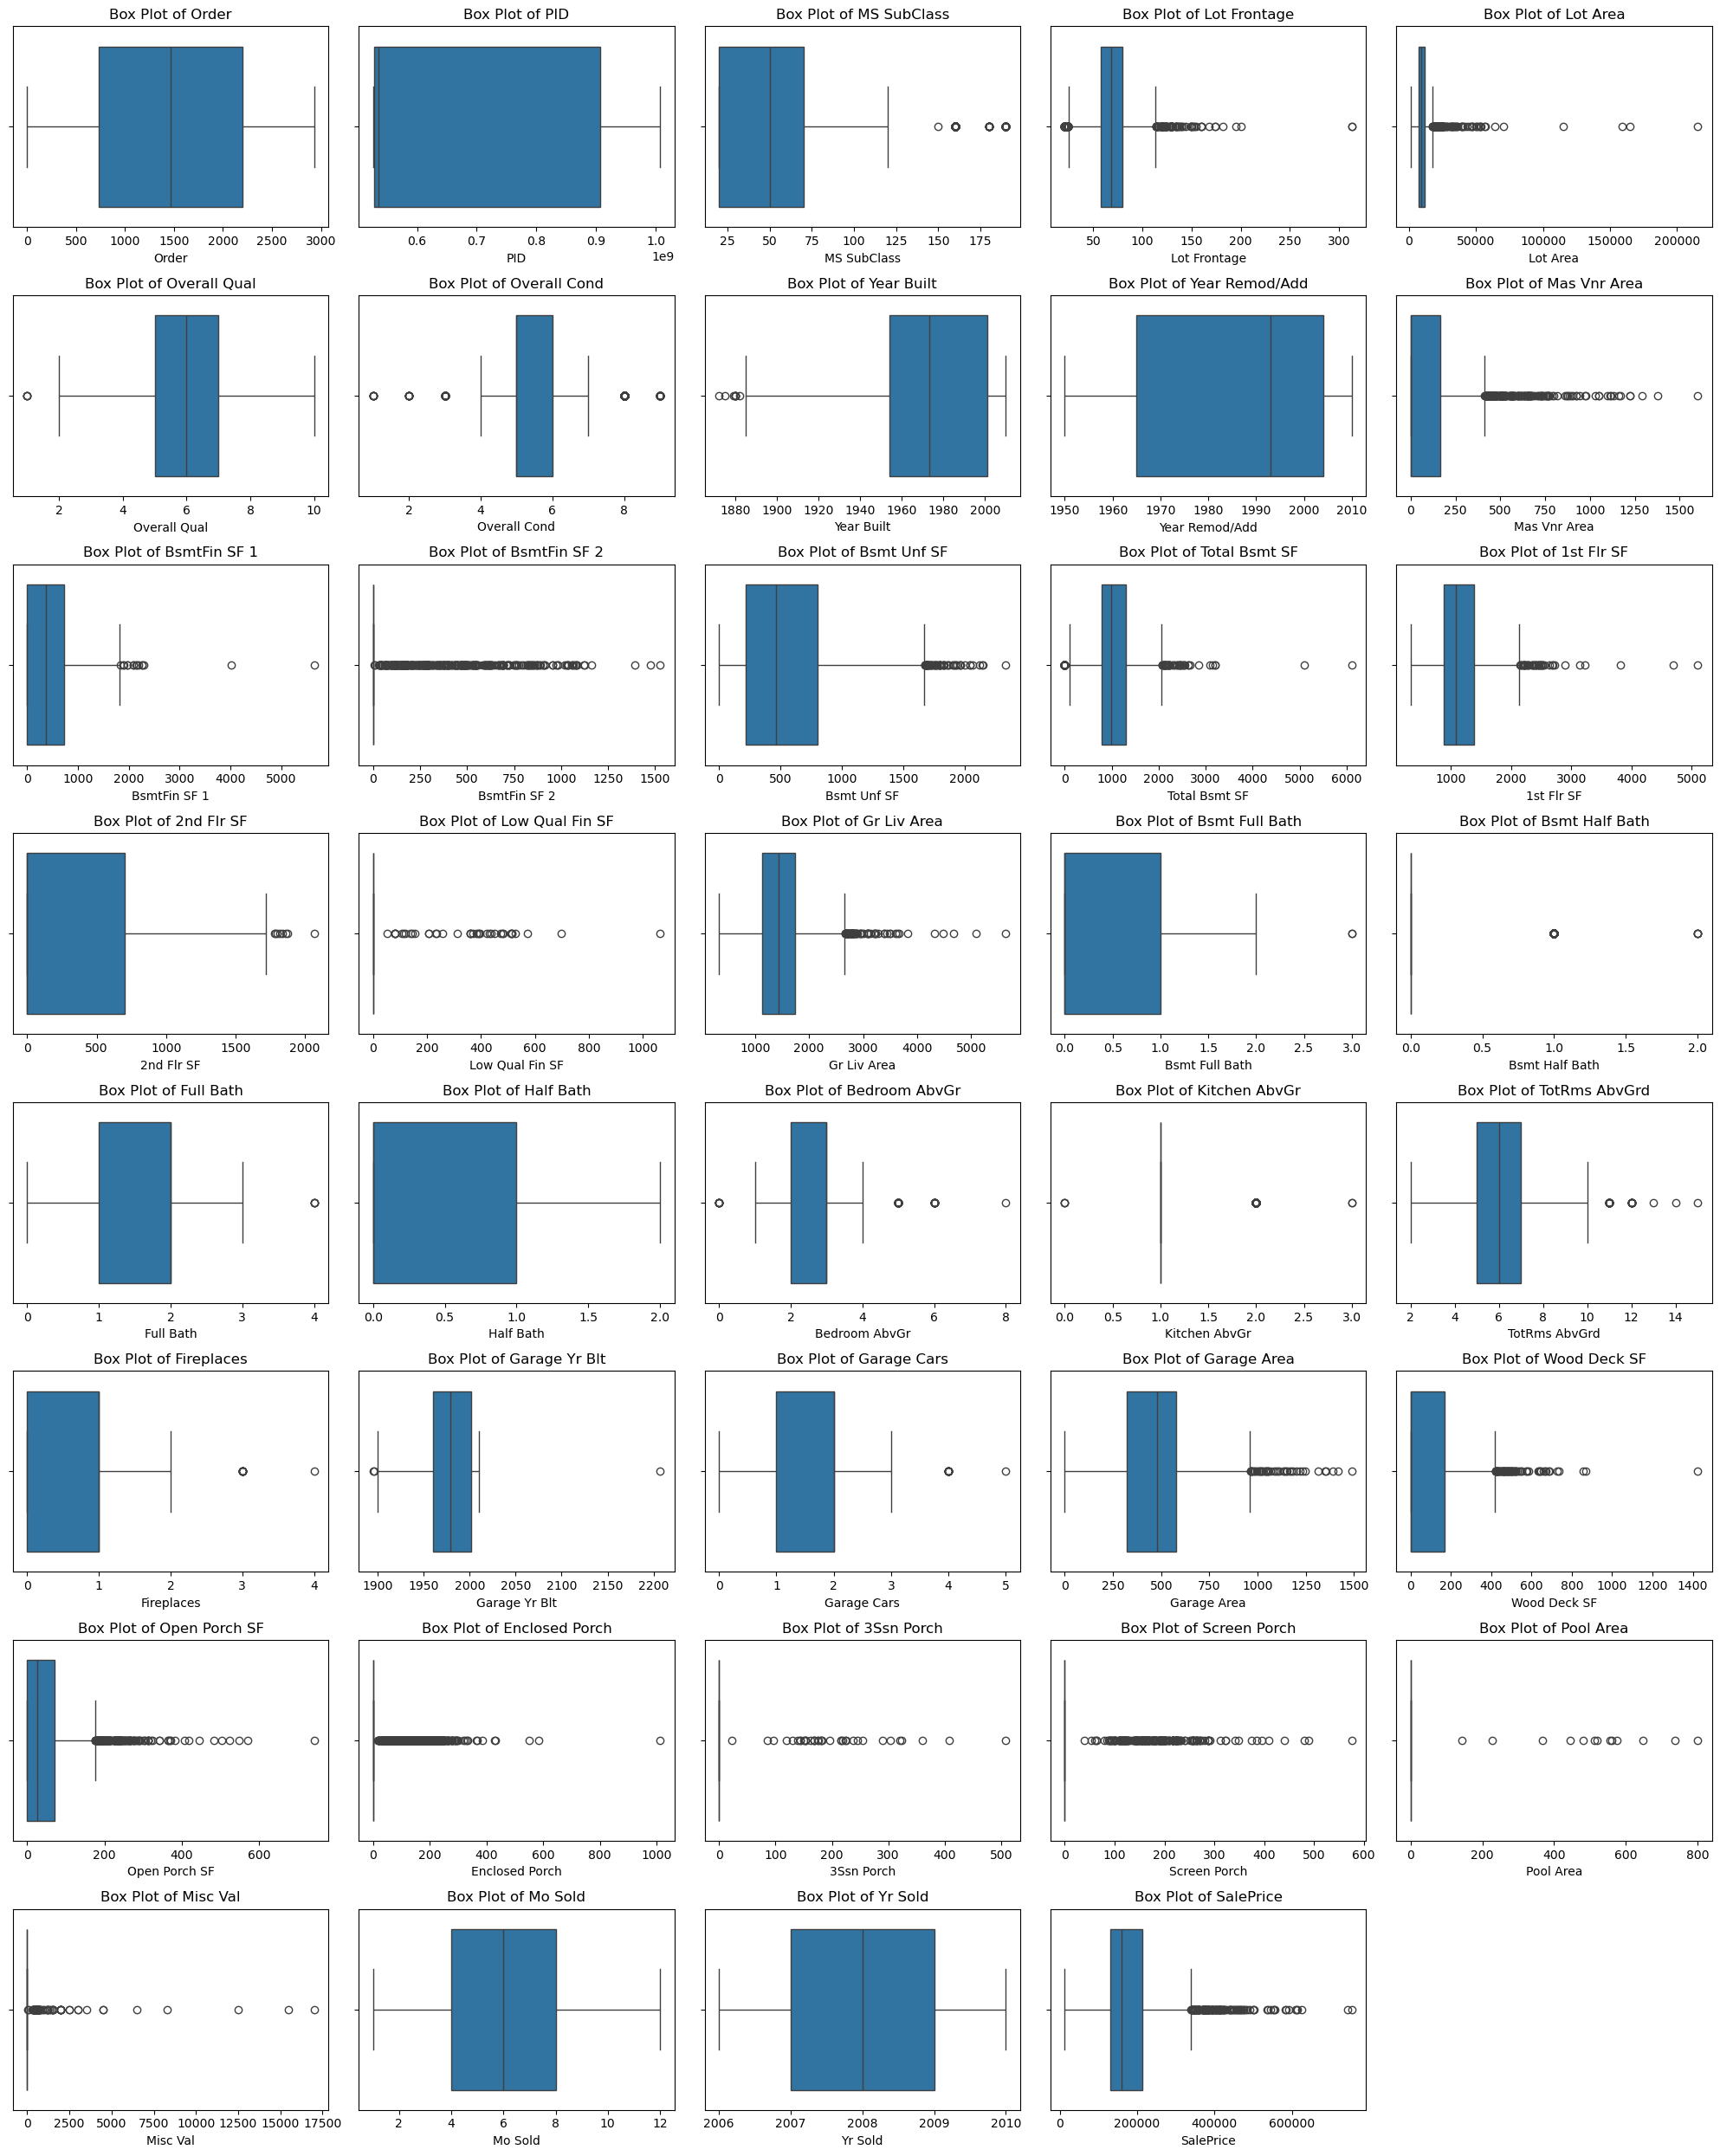

In [11]:
#boxplots to detect and visualize outliers in the numerical features
print("\nBox Plots:")
plt.figure(figsize=(20,25))
for i, feature in enumerate(numerical_features):
    plt.subplot(8, 5, i+1)
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

There are a significant number of outliers which likely represent unique or high value properties, not errors.
These outliers will not be removed but will be handled by the neural network. That coupled with feature scaling should maintain model effectiveness.

Bivariate/Multivariate Analysis

In [12]:
#choosing a list of likely relevant features for regression tasks, feature importance hypothesis
relevant_features = ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', 'Year Built']
#Correlation Matrix
print("\nCorrelation Matrix of Key Numerical Features:")
correlation_matrix = df[relevant_features].corr()
print(correlation_matrix)


Correlation Matrix of Key Numerical Features:
               SalePrice  Overall Qual  Gr Liv Area  Garage Cars  \
SalePrice       1.000000      0.799262     0.706780     0.647877   
Overall Qual    0.799262      1.000000     0.570556     0.599545   
Gr Liv Area     0.706780      0.570556     1.000000     0.488829   
Garage Cars     0.647877      0.599545     0.488829     1.000000   
Total Bsmt SF   0.632280      0.547294     0.444675     0.437608   
Year Built      0.558426      0.597027     0.241726     0.537443   

               Total Bsmt SF  Year Built  
SalePrice           0.632280    0.558426  
Overall Qual        0.547294    0.597027  
Gr Liv Area         0.444675    0.241726  
Garage Cars         0.437608    0.537443  
Total Bsmt SF       1.000000    0.407526  
Year Built          0.407526    1.000000  


Most selected features display weak to strong positive correlation.
Overall Qual and Gr Liv Area show very strong positive correlation with SalePrice.


Pair Plots:


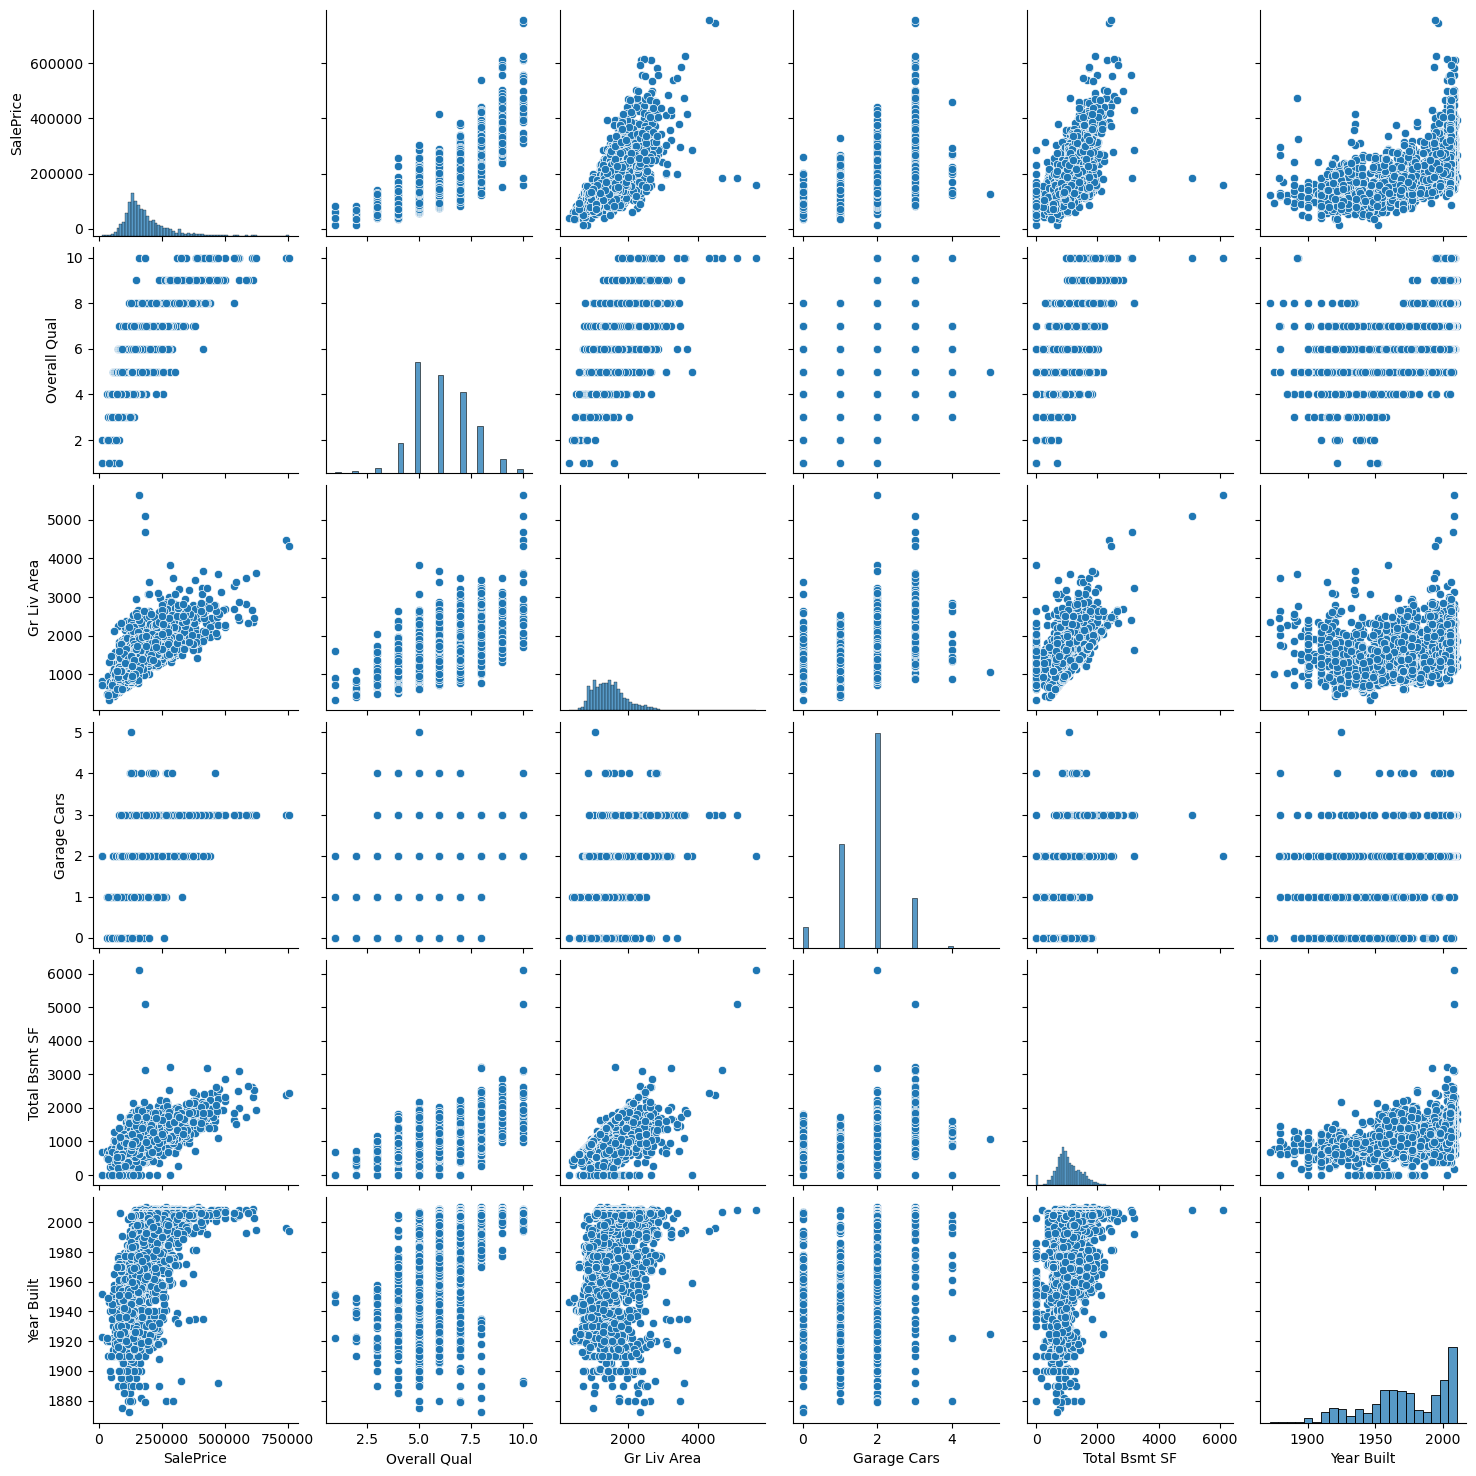

In [13]:
#Pair Plots for pairwise relationships
print("\nPair Plots:")
sns.pairplot(df[relevant_features])
plt.show()

Visually confirming strong positive relationships between the target SalePrice and Gr Liv Area, Overall Qual, and Total Bsmt SF


Correlation Heatmap:


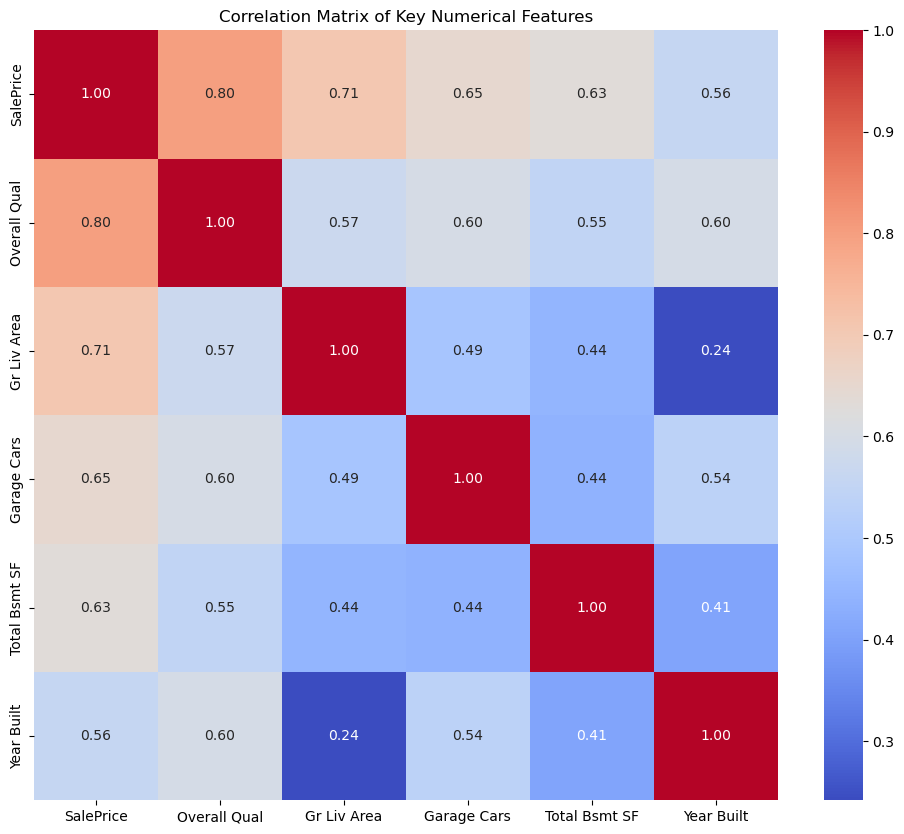

In [14]:
#Heatmap
print("\nCorrelation Heatmap:")
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Numerical Features')
plt.show()

Data Preprocessing

In [4]:
#preparing the data for preprocessing

#drop irrelevant features
df_preprocessed = df.drop(columns=['Order', 'PID'])

#identify target variable and features
X = df_preprocessed.drop(columns=['SalePrice'])
y = df_preprocessed['SalePrice']

#re-define numerical and categorical features to avoid data leakage
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

#identify highly skewed numerical features for log transformation
skewed_features = X[numerical_features].skew().sort_values(ascending=False)
skew_threshold = 0.75
#create a list of column names from the skewed features
highly_skewed_numerical = skewed_features[skewed_features > skew_threshold].index.tolist()

#moving MS SubClass to categorical_features as identified in EDA
if 'MS SubClass' in numerical_features:
    numerical_features.remove('MS SubClass')
    categorical_features.append('MS SubClass')
    #also remove it from the skewed list if it happens to be there
    if 'MS SubClass' in highly_skewed_numerical:
        highly_skewed_numerical.remove('MS SubClass')

#split data into training and testing sets before preprocessing to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nInitial Data Shape")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Initial Data Shape
Shape of X_train: (2344, 79)
Shape of X_test: (586, 79)


Handle Missing Data, Transformation, and Standardization
Pipelines will perform the following;
Features with skewness > 0.75 will have log transformation applied.
Numerical features will be standardized.
Missing values imputed with the median for numerical features and 'None' for categorical.
Categorical features will be one-hot encoded.

In [5]:
#log transform the target variable
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

#create preprocessing pipelines
numerical_skewed_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

numerical_rest_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#combine the transformers into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num_skewed', numerical_skewed_transformer, highly_skewed_numerical),
        ('num_rest', numerical_rest_transformer, [col for col in numerical_features if col not in highly_skewed_numerical]),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

#apply the preprocessing to the data
print("\nPreProcessed Data Shape")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Shape of X_train_processed:", X_train_processed.shape)
print("Shape of X_test_processed:", X_test_processed.shape)


PreProcessed Data Shape
Shape of X_train_processed: (2344, 330)
Shape of X_test_processed: (586, 330)


In [6]:
#getting all the feature names for later use
num_skewed_features_out = preprocessor.named_transformers_['num_skewed'].named_steps['scaler'].get_feature_names_out(highly_skewed_numerical)
num_rest_features_out = preprocessor.named_transformers_['num_rest'].named_steps['scaler'].get_feature_names_out([col for col in numerical_features if col not in highly_skewed_numerical])
cat_features_out = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
passthrough_cols = [col for col in X_train.columns if col not in numerical_features + categorical_features]
passthrough_features = passthrough_cols

# Combine all feature names
all_feature_names = np.concatenate([num_skewed_features_out, num_rest_features_out, cat_features_out, passthrough_features])

# Print the total number of feature names to confirm it matches the number of coefficients
print("Total number of feature names:", len(all_feature_names))

Total number of feature names: 330


There is a significant increase in dimensionality after one-hot encoding. This may lead to complications, but will be left as is until feature analysis can be performed per the project proposal, after which dimensionality reduction techniques may be used to improve performance.

In [12]:
#Preprocessing Verification

#check for any remaining missing values in the processed data
print("\nMissing Values Remaining")
missing_in_train = np.isnan(X_train_processed.toarray()).sum()
missing_in_test = np.isnan(X_test_processed.toarray()).sum()
print(f"Missing values in X_train_processed: {missing_in_train}")
print(f"Missing values in X_test_processed: {missing_in_test}")

#check for standardization
numerical_out_features = highly_skewed_numerical + [col for col in numerical_features if col not in highly_skewed_numerical]
onehot_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_out_features) + list(onehot_feature_names)
processed_X_train_df = pd.DataFrame(X_train_processed.toarray(), columns=all_feature_names)

print("\nMean and Standard Deviation of a few standardized features:")
print(processed_X_train_df[numerical_out_features[:5]].agg(['mean', 'std']).T)


Missing Values Remaining
Missing values in X_train_processed: 0
Missing values in X_test_processed: 0

Mean and Standard Deviation of a few standardized features:
                         mean       std
Misc Val         1.667229e-17  1.000213
Pool Area       -1.818795e-17  1.000213
Lot Area        -1.777873e-15  1.000213
Low Qual Fin SF  1.288313e-17  1.000213
3Ssn Porch      -6.062651e-18  1.000213


Baseline Predictive Model
Choosing Ridge Regression since I am predicting SalePrice which is a continuous value and it will help mitigate overfitting due to high dimensionality.
I will use MAE, MSE, RMSE, and R2 score to evaluate the model's performance and will be used as the benchmark to compare the neural network against.

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#pipeline to combine the preprocesser transformer and ridge regression class
baseline_model_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

#fit the model on raw data
baseline_model_pipe.fit(X_train, y_train_log)

#make predictions on the test set
y_pred_baseline = baseline_model_pipe.predict(X_test)

#reverse log transformation to get original dollar values
y_test_ridge = np.expm1(y_test_log)
y_pred_ridge = np.expm1(y_pred_baseline)

#evaluate results
mae = mean_absolute_error(y_test_ridge, y_pred_ridge)
mse = mean_squared_error(y_test_ridge, y_pred_ridge)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_ridge, y_pred_ridge)


print("Baseline Model Performance (Ridge Regression):")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Mean Squared Error (MSE): ${mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R-squared (R²): {r2:.4f}")

Baseline Model Performance (Ridge Regression):
Mean Absolute Error (MAE): $14,276.62
Mean Squared Error (MSE): $753,626,557.65
Root Mean Squared Error (RMSE): $27,452.26
R-squared (R²): 0.9060


MAE indicates high accuracy since the standard deviation of SalesPrice is  $79,886.69 so the predictions are off by much less than one standard deviation.
RMSE is also less than one standard deviation off, but since it is higher than the MAE, the model made some large prediction errors, indicating it may not be as reliable for homes in the higher price ranges.
R2 is very good as 90.6% of variance is explained by the model, or it makes sense why some houses are cheaper and some are more expensive, based on their features.

Define the Neural Network Architecture:
Building a sequential, feed-forward network with dense layers to learn complex relationships and patterns
Input layer: will match the number of features: 330.
Three Hidden layers: decresasing number of neurons in each, 128, 64, 32.
Activation functions: ReLU to learn non-linear relationships.
Output layer: one neuron with linear activation for predicting a single, continuous value, SalesPrice.

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Input

#initialize sequential model
model = Sequential()
#input layer
input_shape=330
model.add(Input(shape=(input_shape,)))
#add three hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
#output layer
model.add(Dense(1, activation='linear'))
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        42,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,737 (206.00 KB)

 Trainable params: 52,737 (206.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#train the model
history = model.fit(
    X_train_processed.toarray(),
    y_train_log,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

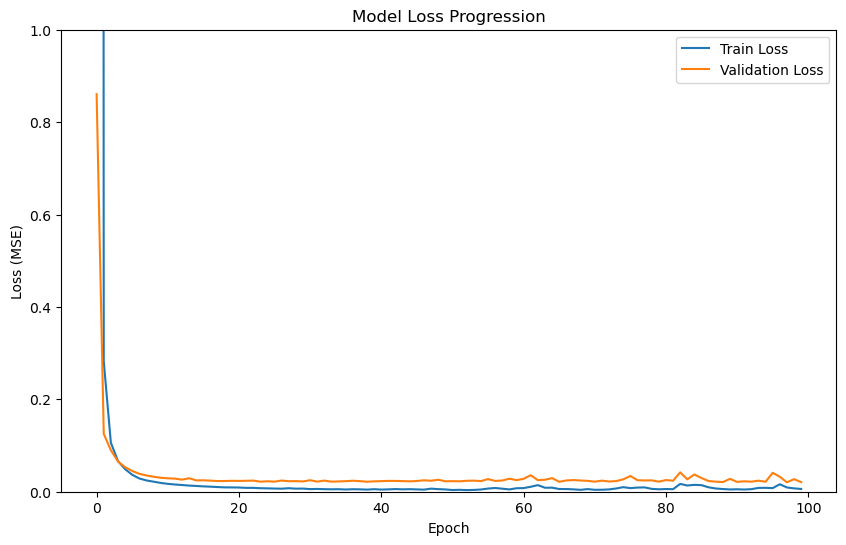

Final Training Loss: 0.0060
Final Validation Loss: 0.0208


In [16]:
#plot the training results
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.ylim(0, 1.0)
plt.legend()
plt.show()

final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Training and Validation loss are both very low, indicating the model learns well on seen and unseen data.
Will apply early stopping in refined model as there is no improvement past 40 epochs and performance might degrade slightly.

In [10]:
#model evaluation

#make predictions with the model, predictions are in log scale
y_pred_nn_log = model.predict(X_test_processed.toarray())

#reverse log transformation to get dollar values
y_test_nn = np.expm1(y_test_log)
y_pred_nn = np.expm1(y_pred_nn_log)

#calculate evaluation metrics
mae_nn = mean_absolute_error(y_test_nn, y_pred_nn)
mse_nn = mean_squared_error(y_test_nn, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test_nn, y_pred_nn)

print("Neural Network Model Performance:")
print(f"Mean Absolute Error (MAE): ${mae_nn:,.2f}")
print(f"Mean Squared Error (MSE): ${mse_nn:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_nn:,.2f}")
print(f"R-squared (R²): {r2_nn:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Neural Network Model Performance:
Mean Absolute Error (MAE): $18,706.93
Mean Squared Error (MSE): $1,423,473,475.32
Root Mean Squared Error (RMSE): $37,728.95
R-squared (R²): 0.8225


The neural network, while performing relatively well, actually performed slightly worse than the baseline ridge regression model.
MAE as about $4k higher and RMSE was around $6k higher indicating more errors and larger errors.
R2 score also dropped about 4%, explaining less variation in the house prices.
This could indicate that the relationships in the data are more linear than not, and the basic model is more effective or the neural network might need further tuning to capture underlying patterns in the data.

Performance Analysis.

While the training and validation loss remained very low, somewhere around 30 to 40 epochs, there was no further improvement and the loss went up very slightly.
Different numbers of hidden layers or neurons could be explored to try and capture more complex relationships.
The learning rate of the optimizer could be adjusted to lower the training loss even further.
Regularization techniques such as L2 regularization could help it to generalize better and bring its performance closer to the baseline model.
Early stopping would make the process more efficient at least and avoid any slight overfitting.

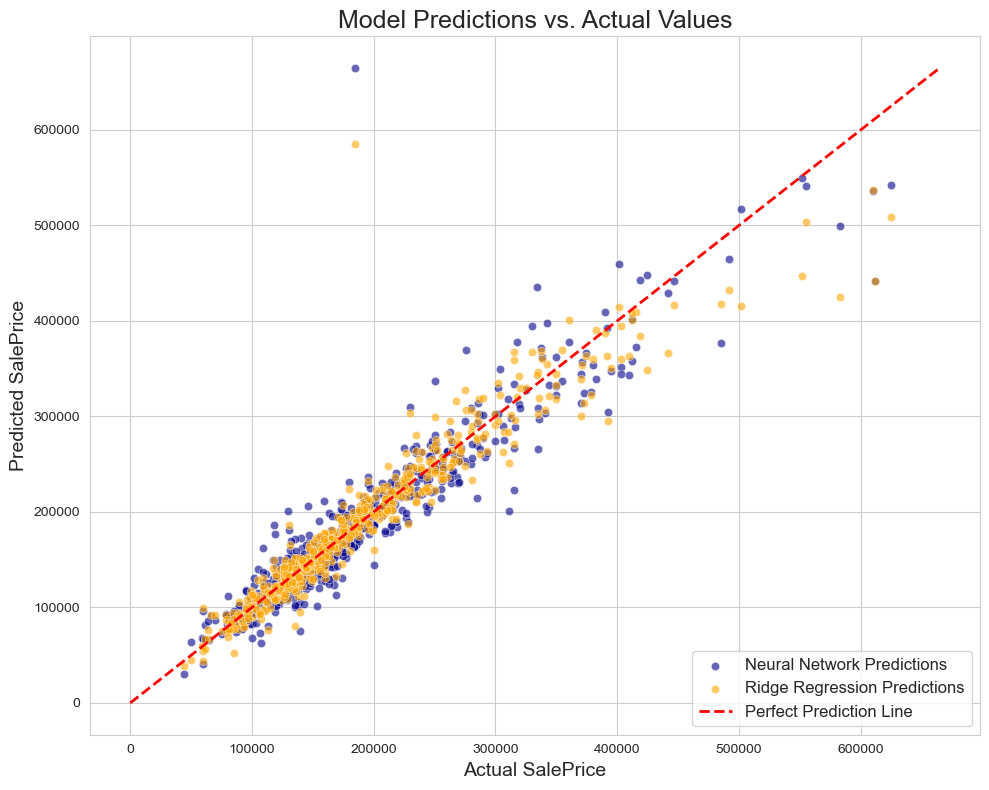

In [18]:
#create a scatter plot to visualize predictions of both models against actual values
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

#one or some of the arrays are not 1-dimensional and need to be flattened
#neural network plot
y_test_nn_flat = y_test_nn.flatten() if hasattr(y_test_nn, 'flatten') else y_test_nn
y_pred_nn_flat = y_pred_nn.flatten() if hasattr(y_pred_nn, 'flatten') else y_pred_nn
sns.scatterplot(x=y_test_nn_flat, y=y_pred_nn_flat, alpha=0.6, label='Neural Network Predictions', color='darkblue')

#ridgeline regression plot
y_test_ridge_flat = y_test_ridge.flatten() if hasattr(y_test_ridge, 'flatten') else y_test_ridge
y_pred_ridge_flat = y_pred_ridge.flatten() if hasattr(y_pred_ridge, 'flatten') else y_pred_ridge
sns.scatterplot(x=y_test_ridge_flat, y=y_pred_ridge_flat, alpha=0.6, label='Ridge Regression Predictions', color='orange')

#perfect prediction line and plot limits
max_val = max(max(y_test_nn_flat), max(y_pred_nn_flat), max(y_pred_ridge_flat))
plt.plot([0, max_val], [0, max_val], '--', color='red', linewidth=2, label='Perfect Prediction Line')

plt.title('Model Predictions vs. Actual Values', fontsize=18)
plt.xlabel('Actual SalePrice', fontsize=14)
plt.ylabel('Predicted SalePrice', fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

Principal Component Analysis

Top 10 features for Principal Component 1 (PC1):
Overall Qual      0.280771
Garage Cars       0.263392
Year Built        0.262710
Garage Area       0.247919
Gr Liv Area       0.245507
Garage Yr Blt     0.242881
Full Bath         0.235398
Year Remod/Add    0.225579
1st Flr SF        0.197188
Open Porch SF     0.191215
Name: PC1, dtype: float64

Top 10 features for Principal Component 2 (PC2):
2nd Flr SF            0.411362
Bedroom AbvGr         0.338809
TotRms AbvGrd         0.336394
Gr Liv Area           0.280575
BsmtFin SF 1          0.260248
Bsmt Full Bath        0.240525
Half Bath             0.213418
Year Built            0.182959
House Style_1Story    0.173084
Full Bath             0.155916
Name: PC2, dtype: float64


<Figure size 1000x600 with 0 Axes>

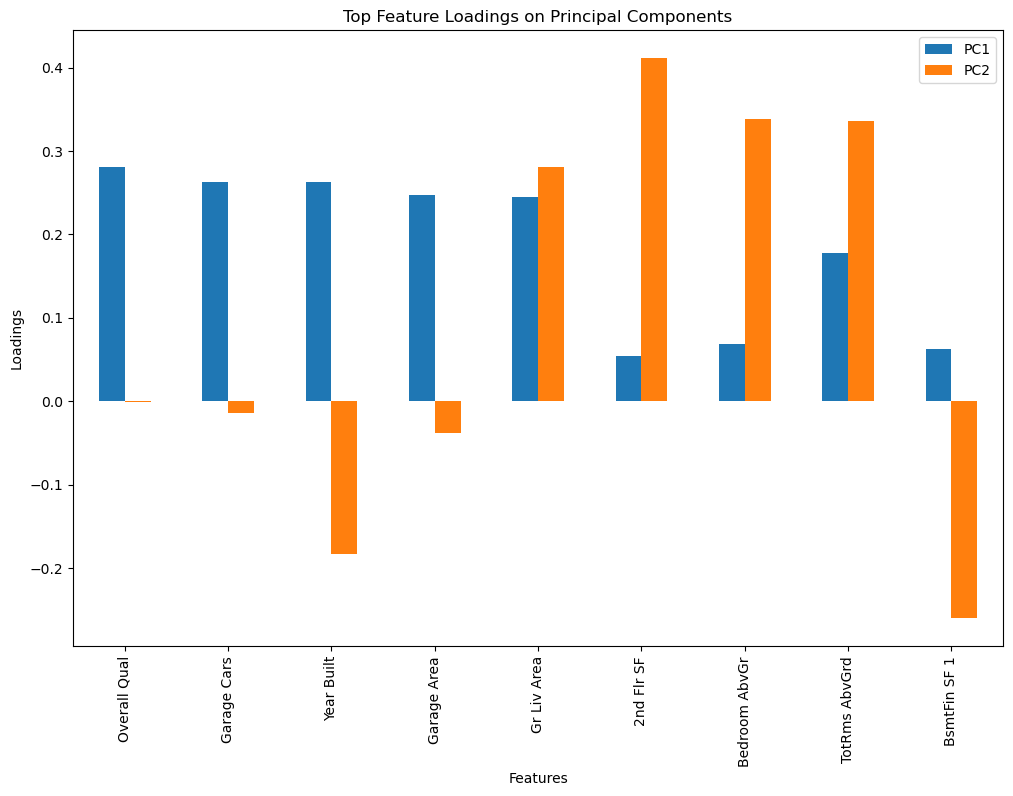

In [11]:
from sklearn.decomposition import PCA

#fit PCA
pca = PCA().fit(X_train_processed.toarray())

#get the loadings for the first two principal components
loadings = pd.DataFrame(pca.components_[:2, :].T, columns=['PC1', 'PC2'], index=all_feature_names)

#sort by absolute value to find the most influential features
top_pc1_features = loadings['PC1'].abs().sort_values(ascending=False).head(10)
top_pc2_features = loadings['PC2'].abs().sort_values(ascending=False).head(10)

print("Top 10 features for Principal Component 1 (PC1):")
print(top_pc1_features)

print("\nTop 10 features for Principal Component 2 (PC2):")
print(top_pc2_features)

#visualize the loadings
plt.figure(figsize=(10, 6))
top_features = pd.concat([top_pc1_features.head(5), top_pc2_features.head(5)]).index.unique()
loadings.loc[top_features].plot(kind='bar', figsize=(12, 8))
plt.title('Top Feature Loadings on Principal Components')
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.show()

The principal component analysis reveals that the primary factors influencing the overall structure and variation within the home feature data are the quality and size of the house. These are represented by features such as Overall Qual, Gr Liv Area, and Year Built

In [12]:
from sklearn.neural_network import MLPRegressor

#since PCA was performed, re-run the models with reduced dimensionality to see if performance improved
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1 #using 95% variance

#ridge pipeline with PCA
ridge_pipeline_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=n_components)),
    ('regressor', Ridge(random_state=42))
])

#neural network pipeline with PCA
nn_pipeline_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=n_components)),
    ('regressor', MLPRegressor(max_iter=1000, random_state=42))
])

#fit and make predictions with the PCA models
ridge_pipeline_pca.fit(X_train, y_train_log)
nn_pipeline_pca.fit(X_train, y_train_log)
y_pred_ridge_pca_log = ridge_pipeline_pca.predict(X_test)
y_pred_nn_pca_log = nn_pipeline_pca.predict(X_test)

#convert predictions back to original scale and get metrics
y_test_original = np.expm1(y_test_log)
y_pred_ridge_pca = np.expm1(y_pred_ridge_pca_log)
y_pred_nn_pca = np.expm1(y_pred_nn_pca_log)

#print the final comparison
print("Final Model Performance Comparison")
print("\nOriginal Models (without PCA):")
print(f"Ridge MAE: ${mae:,.2f}")
print(f"Ridge R-squared: {r2:.4f}")
print(f"NN MAE: ${mae_nn:,.2f}")
print(f"NN R-squared: {r2_nn:.4f}")

print("\nModels with PCA:")
print(f"Ridge PCA MAE: ${mean_absolute_error(y_test_original, y_pred_ridge_pca):,.2f}")
print(f"Ridge PCA R-squared: {r2_score(y_test_original, y_pred_ridge_pca):.4f}")
print(f"NN PCA MAE: ${mean_absolute_error(y_test_original, y_pred_nn_pca):,.2f}")
print(f"NN PCA R-squared: {r2_score(y_test_original, y_pred_nn_pca):.4f}")

Final Model Performance Comparison

Original Models (without PCA):
Ridge MAE: $14,276.62
Ridge R-squared: 0.9060
NN MAE: $18,706.93
NN R-squared: 0.8225

Models with PCA:
Ridge PCA MAE: $16,091.73
Ridge PCA R-squared: 0.8771
NN PCA MAE: $85,998.16
NN PCA R-squared: -2.4892


While PCA was successful for interpreting which features are most important, it significantly reduced both model's performance due to the dimensionality reduction. These models need the full feature set to make the best predictions.

In [21]:
#create overall metrics table for dashboard.
metrics = {
    'Model': ['Ridge Regression', 'Neural Network'],
    'MAE': [mean_absolute_error(dashboard_df['SalePrice'], dashboard_df['Ridge_Predictions']),
            mean_absolute_error(dashboard_df['SalePrice'], dashboard_df['NN_Predictions'])],
    'R2': [r2_score(dashboard_df['SalePrice'], dashboard_df['Ridge_Predictions']),
           r2_score(dashboard_df['SalePrice'], dashboard_df['NN_Predictions'])]
}

metrics_df = pd.DataFrame(metrics)

#exporting metrics table for dashboard
metrics_df.to_csv('model_metrics.csv', index=False)

In [13]:
#dashboard data on whole dataset including predictions for more comprehensive analysis
X_full = df.drop(columns=['Order', 'PID', 'SalePrice'], axis=1)
y_full_log = np.log1p(df['SalePrice'])

X_full_processed_nn = preprocessor.transform(X_full)

full_ridge_predictions_log = baseline_model_pipe.predict(X_full)
full_ridge_predictions = np.expm1(full_ridge_predictions_log)

full_nn_predictions_log = model.predict(X_full_processed_nn).flatten()
full_nn_predictions = np.expm1(full_nn_predictions_log)

comprehensive_dashboard_df = df.copy()
comprehensive_dashboard_df['Ridge_Predictions'] = full_ridge_predictions
comprehensive_dashboard_df['NN_Predictions'] = full_nn_predictions

comprehensive_dashboard_df.to_csv('ames_housing_dashboard_data.csv', index=False)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

New 'ames_housing_dashboard_data.csv' created with predictions for all homes.
It contains 2930 rows.
   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ...  Fence Misc Feature Misc Val Mo Sold  \
0   NaN       IR1          Lvl  ...    NaN          NaN        0       5   
1   NaN       Reg          Lvl  ...  MnPrv          NaN        0       6   
2   NaN       IR1          Lvl  ...    NaN         Gar2    12500       6   
3   NaN       Reg          Lvl  ...    NaN          NaN        0       4   
4   NaN       IR

Running the models by year to track performance over time. This will evaluate if the prediction accuracy is affected at all by market volatility. There should be a general upward trend over time due to more data to learn from, so I will be looking forany anomalies that may appear during the crisis period.

In [22]:
df_processed = df_preprocessed.drop(columns=['Ridge_Predictions', 'NN_Predictions'], errors='ignore')

#create a new DataFrame to store the time-based metrics
metrics_over_time = pd.DataFrame(columns=['Model', 'Year', 'MAE', 'R2'])

#get the list of years from the dataset
years = sorted(df_processed['Yr Sold'].unique())

for year in years[1:]:
    train_data = df_processed[df_processed['Yr Sold'] < year].copy()
    test_data = df_processed[df_processed['Yr Sold'] == year].copy()

    if test_data.empty or train_data.empty:
        continue

    X_train = train_data.drop('SalePrice', axis=1)
    y_train_log = np.log1p(train_data['SalePrice'])
    
    X_test = test_data.drop('SalePrice', axis=1)
    y_test_log = np.log1p(test_data['SalePrice'])
    y_test_orig = np.expm1(y_test_log)

    #ridge model evaluation
    baseline_model_pipe.fit(X_train, y_train_log)
    y_pred_ridge_log = baseline_model_pipe.predict(X_test)
    y_pred_ridge = np.expm1(y_pred_ridge_log)
    
    ridge_mae = mean_absolute_error(y_test_orig, y_pred_ridge)
    ridge_r2 = r2_score(y_test_orig, y_pred_ridge)

    #neural network evaluation
    preprocessor = baseline_model_pipe.named_steps['preprocessor']
    
    #preprocess the data to get the correct input shape
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    #dynamically define and compile the neural network inside the loop
    input_shape = X_train_processed.shape[1]
    
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #re-train the model on the new data split
    model.fit(X_train_processed.toarray(), y_train_log, epochs=20, verbose=0)
    y_pred_nn_log = model.predict(X_test_processed.toarray(), verbose=0)
    y_pred_nn = np.expm1(y_pred_nn_log)
    
    nn_mae = mean_absolute_error(y_test_orig, y_pred_nn)
    nn_r2 = r2_score(y_test_orig, y_pred_nn)

    #store results
    metrics_over_time.loc[len(metrics_over_time)] = ['Ridge', year, ridge_mae, ridge_r2]
    metrics_over_time.loc[len(metrics_over_time)] = ['Neural Network', year, nn_mae, nn_r2]

#export results for dashboard
metrics_over_time.to_csv('model_metrics_by_year.csv', index=False)

In [28]:
#get the coefficients from the fitted Ridge model for feature analysis dashboare
ridge_coefficients = baseline_model_pipe.named_steps['regressor'].coef_

#create a DataFrame
coefficients_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': ridge_coefficients
})

#add a column for the absolute value to measure importance
coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])

#sort by importance
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

#export to CSV
coefficients_df.to_csv('ridge_coefficients.csv', index=False)

Scenario Analysis

These scenarios are meant to simulate users learning from, and applying improvements to their homes based on the findings of this program. The overall goal was to not only predict home sale prices, regardless of volatile market conditions, but to educate average home buyers and sellers and what features drive the sale price in order to make informed decisions when buying, selling, or renovating a home.

Scenario 1: Luxury Upgrade targeting average homes (quality rating 5 -7)
    Features for average homes will be "upgraded" to the most positively correlated features to determine of sale price is driven up. Home improvement, sparing no expense. 
    Features to change;
        Change roof material to Roof Matl_WdShngl (wood shingles, highest positive coefficient)
        Gr Liv Area increase by 10%
        Change garage quality to Garage Qual_Ex (excellent garage quality)

Scenario 2: Fixer Upper targeting lower quality homes (ratings 1 - 6)
    All homes in this quality range that have these negative features will be upgraded to a more neutral option. Home improvement on a budget.
    Features to change;
        Roof Matl_ClyTile to Roof Matl_Tar&Grv (tar and gravel roof, cheap and widely available and not too shabby)
        Exter Cond_Po to Exter Cond_Fa (exterior condition poor to fair)
        Functional_Sal to Functional_Typ (home functionality from severe damage to typical functionality)
        
Scenario 3: Green Renovation targeting all homes in the dataset
    Features related to heating and cooling will be changed to more eco friendly options to test their impact on sale price.
    Features to change;
        Heating change all to GasA (Gas forced air, modern and efficient system)
        Heating QC change all to Ex (excellent quality systems)
        Central Air (no to yes)

In [18]:
#define scenario function

def create_scenario_data(df, scenario_name):
    scenario_df = df.copy()

    #resolving incompatible dtype warning
    scenario_df['Gr Liv Area'] = scenario_df['Gr Liv Area'].astype('float64')
    
    if scenario_name == 'luxury':
        #target homes with overall quality between 5 and 7
        target_indices = scenario_df.loc[(scenario_df['Overall Qual'] >= 5) & (scenario_df['Overall Qual'] <= 7)].index
        #adjust features for only these homes
        if not target_indices.empty:
            #change roof material to wood shingles
            scenario_df.loc[target_indices, 'Roof Matl'] = 'WdShngl'
            #increase ground living area by 10%
            scenario_df.loc[target_indices, 'Gr Liv Area'] *= 1.10
            #change garage quality to excellent
            scenario_df.loc[target_indices, 'Garage Qual'] = 'Ex'
            print(f"Luxury scenario applied to {len(target_indices)} homes.")
        else:
            print("No homes found")
            
    elif scenario_name == 'fixer':
        #target homes with overall quality between 1 and 6
        target_indices = scenario_df.loc[(scenario_df['Overall Qual'] >= 1) & (scenario_df['Overall Qual'] <= 6)].index
        #adjust features for only these homes
        if not target_indices.empty:
            #change roof material from clay tile to tar and gravel
            scenario_df.loc[(scenario_df.index.isin(target_indices)) & (scenario_df['Roof Matl'] == 'ClyTile'), 'Roof Matl'] = 'Tar&Grv'
            #change exterior condition from poor to fair
            scenario_df.loc[(scenario_df.index.isin(target_indices)) & (scenario_df['Exter Cond'] == 'Po'), 'Exter Cond'] = 'Fa'
            #change home functionality from severe damage to typical
            scenario_df.loc[(scenario_df.index.isin(target_indices)) & (scenario_df['Functional'] == 'Sal'), 'Functional'] = 'Typ'
            print(f"Fixer Upper scenario applied to {len(target_indices)} homes.")
        else:
            print("No homes found")
            
    elif scenario_name == 'green':
        #apply changes to all homes in the dataset
        #change heating type to gas forced air
        scenario_df['Heating'] = 'GasA'
        #change heating quality to excellent
        scenario_df['Heating QC'] = 'Ex'
        #change central air to yes
        scenario_df['Central Air'] = scenario_df['Central Air'].replace({'N': 'Y'})
        print(f"Green Renovation scenario applied to all {len(scenario_df)} homes.")

    return scenario_df

In [19]:
#generating scenario dataframes
luxury_raw_df = create_scenario_data(df, 'luxury')
fixer_raw_df = create_scenario_data(df, 'fixer')
green_raw_df = create_scenario_data(df, 'green')

#dropping identifiers and target
X_luxury_raw = luxury_raw_df.drop(columns=['Order', 'PID', 'SalePrice'], axis=1)
X_fixer_raw = fixer_raw_df.drop(columns=['Order', 'PID', 'SalePrice'], axis=1)
X_green_raw = green_raw_df.drop(columns=['Order', 'PID', 'SalePrice'], axis=1)

#running scenario therough preprocessor
X_luxury_processed = preprocessor.transform(X_luxury_raw)
X_fixer_processed = preprocessor.transform(X_fixer_raw)
X_green_processed = preprocessor.transform(X_green_raw)

#make predictions for each scenario
luxury_pred_log = model.predict(X_luxury_processed)
fixer_pred_log = model.predict(X_fixer_processed)
green_pred_log = model.predict(X_green_processed)

#reverse log transformation to get SalePrice in dollars
luxury_pred = np.expm1(luxury_pred_log)
fixer_pred = np.expm1(fixer_pred_log)
green_pred = np.expm1(green_pred_log)

Luxury scenario applied to 2159 homes.
Fixer Upper scenario applied to 1840 homes.
Green Renovation scenario applied to all 2930 homes.
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [25]:
#exporting results
#storing original sales prices
original_sales_prices = df['SalePrice'].values


#creating dataframes for each scenario's results
df_luxury_results = pd.DataFrame({
    'Order': df['Order'].values,
    'Original_SalePrice': original_sales_prices,
    'Predicted_SalePrice': luxury_pred.flatten(),
    'Scenario': 'Luxury Upgrade',
    'Yr Sold': df['Yr Sold'].values
})

df_fixer_results = pd.DataFrame({
    'Order': df['Order'].values,
    'Original_SalePrice': original_sales_prices,
    'Predicted_SalePrice': fixer_pred.flatten(),
    'Scenario': 'Fixer Upper',
    'Yr Sold': df['Yr Sold'].values
})

df_green_results = pd.DataFrame({
    'Order': df['Order'].values,
    'Original_SalePrice': original_sales_prices,
    'Predicted_SalePrice': green_pred.flatten(),
    'Scenario': 'Green Renovation',
    'Yr Sold': df['Yr Sold'].values
})

#concatenate into a single dataframe
all_scenario_predictions = pd.concat([df_luxury_results, df_fixer_results, df_green_results])

#export to csv
all_scenario_predictions.to_csv('scenario_predictions.csv', index=False)